<a href="https://colab.research.google.com/github/AmandinChyba/Project1-Fields-2022/blob/main/Deep_Learning/stupid_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import jax.numpy as jnp
import numpy as np
import jax
import jax.lax as lax

In [4]:
def getData():
  data = np.load('drive/MyDrive/wob_piecwise_data.npz')
  return data['x'], data['y']

In [5]:
def test_train_split(x, y, train_percentage=0.9):
  x = jnp.array(x)
  y = jnp.array(y)

  sample_size, dimensions = x.shape

  split_index = int(jnp.ceil(sample_size * train_percentage))

  x_train = x[:split_index]
  y_train = y[:split_index]
  x_test = x[split_index:]
  y_test = y[split_index:]

  return x_train, y_train, x_test, y_test

In [6]:
@jax.jit
def T0(x):
  return jnp.ones(len(x))

@jax.jit
def T1(x):
  return x

@jax.jit
def T2(x):
  return 2 * jnp.power(x, 2) - 1

@jax.jit
def T3(x):
  return 4 * jnp.power(x, 3) - 3 * x

In [7]:
@jax.jit
def basis(x):
  # this array creation is required because its an array of different functions at each element
  # so don't @ me
  Tx0 = jnp.array([[T0(x[0]), T1(x[0]), T2(x[0]), T3(x[0])]])
  Tx1 = jnp.array([[T0(x[1]), T1(x[1]), T2(x[1]), T3(x[1])]])
  
  big = Tx0 * Tx1.transpose(1, 0, 2)
  flat = jnp.reshape(big, (-1, big.shape[2]))
  return flat

In [8]:
def gradientDescentStep(i, c):
  f = basis(x_train.T)
  u = np.sum(c * f, axis=0, keepdims=True)
  
  c = c - lr * (u - y_train.T) * f
  c = jnp.mean(c, 1, keepdims=True)
  return c

In [12]:
%%time
polynomials_amount = 4
c = jnp.zeros((jnp.power(polynomials_amount,2), 1))
lr = 0.1
epochs = 400

x, y = getData()
x_train, y_train, x_test, y_test = test_train_split(x,y)

c = lax.fori_loop(0, epochs, gradientDescentStep, c)

CPU times: user 45.5 ms, sys: 0 ns, total: 45.5 ms
Wall time: 47.6 ms


In [24]:
preds = jnp.sum(c * basis(x_test.T), axis=0, keepdims=True)

# Graphing

In [16]:
import matplotlib.pyplot as plt

mean 0.021222519
std 0.033596367
median 0.0113708265


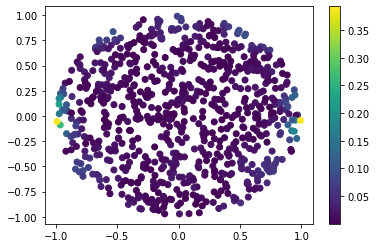

In [29]:
error = jnp.abs(preds - y_test.T)
print('mean', error.mean())
print('std', error.std())
print('median', jnp.median(error))

plt.scatter(x_test[:,0], x_test[:,1], c=error)
plt.colorbar()